In [3]:
import math
import os

import torch
import torch.nn as nn
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

import lpips
from model import Generator
import numpy as np
from util import *
import matplotlib.pyplot as plt

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
def gaussian_loss(v):
    # [B, 9088]
    loss = (v-gt_mean) @ gt_cov_inv.to('mps') @ (v-gt_mean).transpose(1,0)
    return loss.mean()

def get_lr(t, initial_lr, rampdown=0.25, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp

def make_image(tensor):
    return (
        tensor.detach()
        .clamp_(min=-1, max=1)
        .add(1)
        .div_(2)
        .mul(255)
        .type(torch.uint8)
        .permute(0, 2, 3, 1)
        .to('cpu')
        .numpy()
    )

In [5]:
import tensorflow as tf
cpus = tf.config.experimental.list_physical_devices('cpu')
for cpu in cpus:
    tf.config.experimental.set_memory_growth(cpu, True)

from retinaface import RetinaFace
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math

img_path = 'imgs/Dami.jpg'

resp = RetinaFace.detect_faces(img_path)

print(resp)

{'face_1': {'score': 0.9992223978042603, 'facial_area': [238, 95, 409, 331], 'landmarks': {'right_eye': [291.49854, 187.91371], 'left_eye': [371.6327, 190.57137], 'nose': [334.17307, 243.79855], 'mouth_right': [297.9692, 281.08142], 'mouth_left': [354.09344, 283.25583]}}}


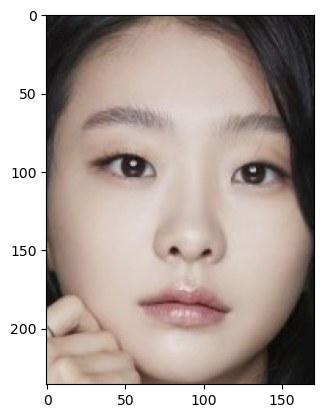

In [6]:
import cv2

img = cv2.imread(img_path)
img = img[:, :, ::-1]

facial_area = resp['face_1']['facial_area']
landmarks = resp['face_1']["landmarks"]
left_eye = landmarks["left_eye"]
right_eye = landmarks["right_eye"]
nose = landmarks["nose"]
mouth_right = landmarks["mouth_right"]
mouth_left = landmarks["mouth_left"]

face_img = img[facial_area[1]: facial_area[3], facial_area[0]: facial_area[2]]

plt.imshow(face_img)

1.8995298805663474


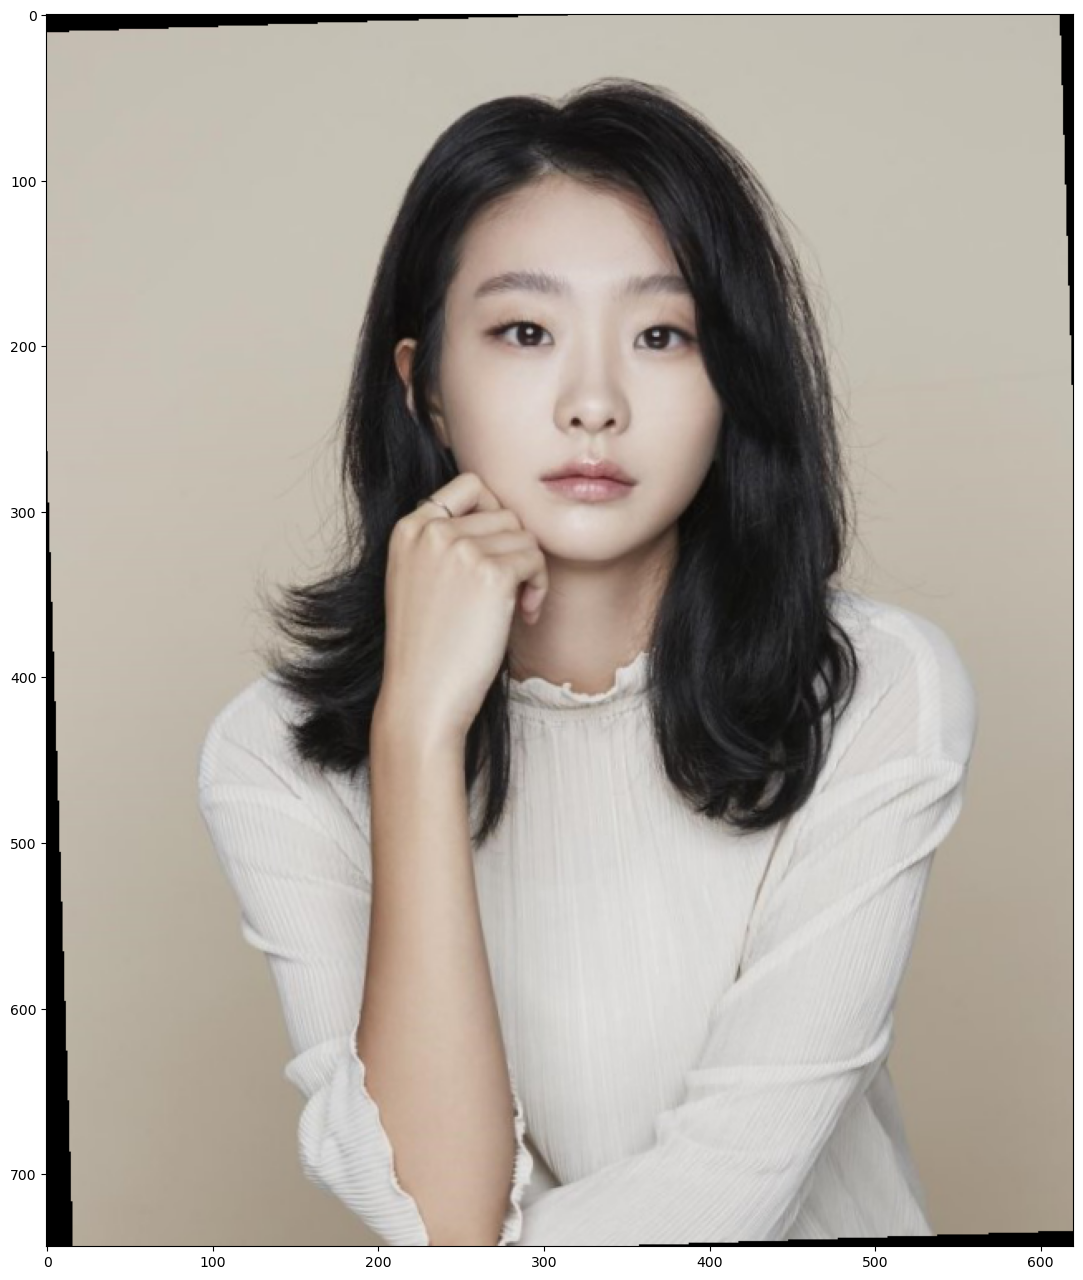

In [7]:
# swap
left_eye, right_eye = right_eye, left_eye

left_eye_x, left_eye_y = left_eye
right_eye_x, right_eye_y = right_eye

center_eyes = (int((left_eye_x + right_eye_x) / 2), int((left_eye_y + right_eye_y) / 2))

if left_eye_y > right_eye_y:
    point_3rd = (right_eye_x, left_eye_y)
    direction = -1 #rotate same direction to clock
else:
    point_3rd = (left_eye_x, right_eye_y)
    direction = 1 #rotate inverse direction of clock

#-----------------------
#find length of triangle edges

a = np.linalg.norm(np.array(left_eye) - np.array(point_3rd))
b = np.linalg.norm(np.array(right_eye) - np.array(point_3rd))
c = np.linalg.norm(np.array(right_eye) - np.array(left_eye))

if b != 0 and c != 0: #this multiplication causes division by zero in cos_a calculation
    cos_a = (b*b + c*c - a*a)/(2*b*c)
    
    #PR15: While mathematically cos_a must be within the closed range [-1.0, 1.0], floating point errors would produce cases violating this
    #In fact, we did come across a case where cos_a took the value 1.0000000169176173, which lead to a NaN from the following np.arccos step
    cos_a = min(1.0, max(-1.0, cos_a))
    
    
    angle = np.arccos(cos_a) #angle in radian
    angle = (angle * 180) / math.pi #radian to degree

    #-----------------------
    #rotate base image

    if direction == -1:
        angle = 90 - angle

    rotated_img = Image.fromarray(img)
    rotated_img = np.array(rotated_img.rotate(direction * angle, center=nose, resample=Image.Resampling.BILINEAR))

    if center_eyes[1] > nose[1]:
        rotated_img = Image.fromarray(rotated_img)
        rotated_img = np.array(rotated_img.rotate(180))

print(angle)
plt.figure(figsize=(16, 16))
plt.imshow(rotated_img)

(354, 354, 3)


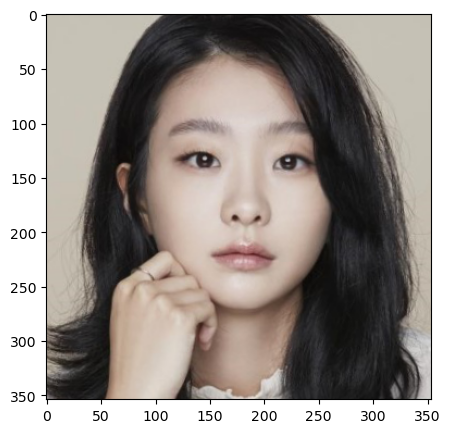

In [8]:
w, h = facial_area[2] - facial_area[0], facial_area[3] - facial_area[1]
cx, cy = (facial_area[0] + facial_area[2]) / 2, (facial_area[1] + facial_area[3]) / 1.8

margin_ratio = 1.5

crop_size = max(w, h) * margin_ratio

x1 = max(0, int(cx - crop_size / 2))
x2 = int(cx + crop_size / 2)
y1 = max(0, int(cy - crop_size / 2))
y2 = int(cy + crop_size / 2)

face_img = rotated_img[y1:y2, x1:x2]

print(face_img.shape)
plt.figure(figsize=(5, 5))
plt.imshow(face_img)

In [9]:
resize = 256

transform = transforms.Compose(
    [
        transforms.Resize(resize),
        transforms.CenterCrop(resize),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

In [10]:
device = 'mps'

#conver array into image
imgfile = Image.fromarray(face_img)
imgs = []

img = transform(imgfile)
imgs.append(img)

imgs = torch.stack(imgs, 0).to(device)

imgs.shape

torch.Size([1, 3, 256, 256])

In [11]:
g_ema = Generator(resize, 512, 8)
ensure_checkpoint_exists('face.pt')
g_ema.load_state_dict(torch.load('face.pt', map_location='mps')['g_ema'], strict=False)
g_ema = g_ema.to(device).eval()

In [12]:
with torch.no_grad():
    latent_mean = g_ema.mean_latent(50000)
    latent_in = list2style(latent_mean)

# get gaussian stats
if not os.path.isfile('inversion_stats.npz'):
    with torch.no_grad():
        source = list2style(g_ema.get_latent(torch.randn([10000, 512],device='mps'))).cpu().numpy()
        gt_mean = source.mean(0)
        gt_cov = np.cov(source, rowvar=False)

    # We show that style space follows gaussian distribution
    # An extension from this work https://arxiv.org/abs/2009.06529
    np.savez('inversion_stats.npz', mean=gt_mean, cov=gt_cov)

data = np.load('inversion_stats.npz')
gt_mean = torch.tensor(data['mean'],device='mps').view(1,-1).float()
gt_cov_inv = torch.tensor(data['cov'],dtype=torch.float32)

# Only take diagonals
mask = torch.eye(*gt_cov_inv.size())
gt_cov_inv = torch.inverse(gt_cov_inv*mask).float()

In [14]:
step = 3000
lr = 1.0

percept = lpips.LPIPS(net='vgg', spatial=True).to('mps')
latent_in.requires_grad = True

optimizer = optim.Adam([latent_in], lr=lr, betas=(0.9, 0.999))

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]
Loading model from: /opt/homebrew/Caskroom/miniforge/base/envs/GAN2/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


In [15]:
min_latent = None
min_loss = 100
pbar = tqdm(range(step))
latent_path = []

for i in pbar:
    t = i / step
#     lr = get_lr(t, lr)
    if i > 0 and i % 500 == 0:
        lr *= 0.2
    latent_n = latent_in

    img_gen, _ = g_ema(style2list(latent_n))

    batch, channel, height, width = img_gen.shape

    if height > 256:
        img_gen = F.interpolate(img_gen, size=(256,256), mode='area')

    p_loss = 20*percept(img_gen, imgs).mean()
    mse_loss = 1*F.mse_loss(img_gen, imgs)
    g_loss = 1e-3*gaussian_loss(latent_n)

    loss = p_loss + mse_loss + g_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i + 1) % 100 == 0:
        latent_path.append(latent_in.detach().clone())
        
    if loss.item() < min_loss:
        min_loss = loss.item()
        min_latent = latent_in.detach().clone()

    pbar.set_description(
        (
            f'loss: {loss.item():.4f}; '
            f'perceptual: {p_loss.item():.4f}; '
            f'mse: {mse_loss.item():.4f}; gaussian: {g_loss.item():.4f} lr: {lr:.4f}'
        )
    )
    
latent_path.append(latent_in.detach().clone()) # last latent vector

print(min_loss)

loss: 4.5651; perceptual: 3.0794; mse: 0.0203; gaussian: 1.4654 lr: 0.0003: 100%|██████████| 3000/3000 [1:04:15<00:00,  1.29s/it]

4.203522682189941


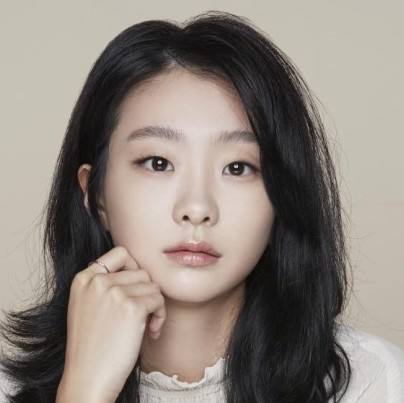

In [ ]:
#original file
Image.open(imgfile)

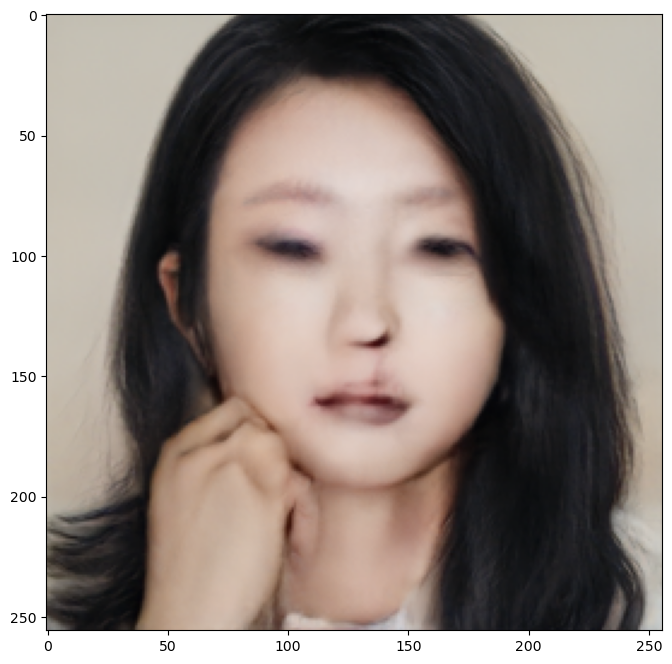

In [16]:
img_gen, _ = g_ema(style2list(latent_path[-1]))

plt.figure(figsize=(8, 8))
plt.imshow(make_image(img_gen)[0])

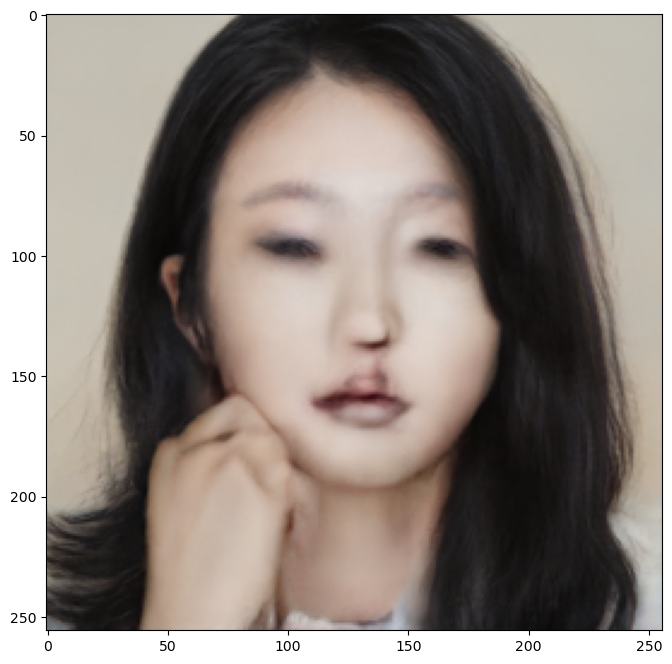

In [17]:
img_gen, _ = g_ema(style2list(min_latent))

plt.figure(figsize=(8, 8))
plt.imshow(make_image(img_gen)[0])

In [7]:
torch.save({'latent': 4.203522682189941}, 'inversion_codes/Dami.pt')